In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.modeling.models import Sersic2D
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_id_2d import Gen_multibeams, Gen_temp_dict, args
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism
from astropy.wcs import wcs

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [22]:
buldge_cat = Table.read(fits.open('../dataframes/galaxy_frames/goods_bulge.fits'), format = 'fits').to_pandas()

In [23]:
SF_GSD = pd.read_pickle('../Casey_data/massMetal_GSD.pkl')
SF_GND = pd.read_pickle('../Casey_data/massMetal_GND.pkl')

Q_GSD = pd.read_pickle('../dataframes/galaxy_frames/GS_cnd.pkl')
Q_GND = pd.read_pickle('../dataframes/galaxy_frames/GN_cnd.pkl')

In [24]:
def find_cand_id(gal_ra, gal_dec, cat_ra, cat_dec, cat_id, galid):
    r = (1. / 60 / 60) * 0.05
    for i in range(len(gal_ra)):
        cosr = np.sin(np.radians(gal_dec[i])) * np.sin(np.radians(cat_dec)) + np.cos(np.radians(gal_dec[i]))\
                * np.cos(np.radians(cat_dec)) * np.cos(np.radians(gal_ra[i]) - np.radians(cat_ra))
        rad = np.arccos(cosr)
        rad = np.degrees(rad)
        for ii in range(len(rad)):
            if rad[ii] < r:
                galid[i] = cat_id[ii]
    return galid

In [25]:
galid = np.repeat(-99.0, len(buldge_cat.ra))

inouts = find_cand_id(buldge_cat.ra.values,  buldge_cat.dec.values, Q_GSD.ra.values, Q_GSD.dec.values, Q_GSD.id.values, galid)
inouts = find_cand_id(buldge_cat.ra.values,  buldge_cat.dec.values, Q_GND.ra.values, Q_GND.dec.values, Q_GND.id.values, galid)
inouts = find_cand_id(buldge_cat.ra.values,  buldge_cat.dec.values, SF_GSD.RA.values, SF_GSD.DEC.values, SF_GSD.ID.values, galid)
inouts = find_cand_id(buldge_cat.ra.values,  buldge_cat.dec.values, SF_GND.RA.values, SF_GND.DEC.values, SF_GND.ID.values, galid)


In [26]:
buldge_cat['threeDHST_id'] = np.array(inouts).astype(int)

In [27]:
len(buldge_cat.query('threeDHST_id > 0'))

76

In [28]:
incat = buldge_cat.query('threeDHST_id > 0')

In [29]:
mdb = pd.read_pickle('../dataframes/fitdb/fullfitdb.pkl')
SFdb = pd.read_pickle('../Casey_data/SF_db_p1.pkl')

In [30]:
buldge_cat

,idx,candels_id,ra,dec,field,Hmag,UV_col,z,z_type,z_phot,...,stack_flux_100um,stack_flux_160um,stack_cov_100um,stack_cov_160um,flux_100um,flux_160um,flux_250um,flux_350um,flux_500um,threeDHST_id
0,236,237,53.108734,-27.941780,1,20.090000,1.800001,0.5197,1,0.531,...,0.190091,0.219145,177.484205,349.054038,-99.00000,-99.00000,-99.000000,-99.000000,-99.000000,-99
1,305,306,53.089714,-27.938513,1,21.930000,1.900000,1.4830,0,1.483,...,0.493474,2.691415,197.710665,389.888223,-99.00000,-99.00000,-99.000000,-99.000000,-99.000000,-99
2,363,364,53.105831,-27.936079,1,22.459999,1.799999,1.2520,0,1.252,...,-0.225823,-0.826958,195.031623,386.778483,-99.00000,-99.00000,-99.000000,-99.000000,-99.000000,-99
3,481,482,53.103519,-27.933323,1,21.990000,1.540001,1.0490,1,1.109,...,0.157994,-0.542957,207.549493,411.343797,-99.00000,-99.00000,-99.000000,-99.000000,-99.000000,-99
4,502,503,53.081944,-27.933586,1,19.790001,2.100000,0.6749,1,0.674,...,-0.255356,-0.816539,213.040261,421.794356,-99.00000,-99.00000,-99.000000,-99.000000,-99.000000,-99
5,513,514,53.131786,-27.934723,1,18.620001,2.070000,0.3970,0,0.397,...,0.522051,-0.066666,186.548228,369.895331,-99.00000,-99.00000,-99.000000,-99.000000,-99.000000,-99
6,527,528,53.113468,-27.933294,1,19.889999,1.610001,1.0887,1,0.997,...,-99.000000,-99.000000,201.827978,400.105925,6.26616,10.66880,12.065614,-99.000000,-99.000000,-99
7,579,580,53.087322,-27.929548,1,22.530001,1.719999,2.3530,0,2.625,...,-0.079515,0.713178,228.733623,435.365454,-99.00000,-99.00000,2.958808,-99.000000,-99.000000,-99
8,803,804,53.137962,-27.923832,1,20.299999,1.960001,0.6720,1,0.638,...,0.016922,5.378526,214.509344,424.633894,-99.00000,-99.00000,-99.000000,-99.000000,-99.000000,-99
9,871,872,53.116894,-27.924069,1,19.270000,2.029999,0.6650,1,0.626,...,0.031536,0.099166,232.905101,452.371092,-99.00000,-99.00000,-99.000000,-99.000000,-99.000000,-99


In [31]:
inout = np.repeat(0, len(mdb))
idx = 0
for i in mdb.index:
    if mdb.field[i] == 'GSD' and mdb.id[i] in incat.query('field == 1').threeDHST_id.values:
        inout[idx] = incat.query('field == 1 and threeDHST_id == {}'.format(mdb.id[i])).candels_id.values[0]
        
    if mdb.field[i] == 'GND' and mdb.id[i] in incat.query('field == 2').threeDHST_id.values:
        inout[idx] = incat.query('field == 2 and threeDHST_id == {}'.format(mdb.id[i])).candels_id.values[0]
        
    idx +=1
mdb['candels_id'] = inout
    
inout = np.repeat(0, len(SFdb))
idx = 0
for i in SFdb.index:
    if SFdb.field[i] == 'GSD' and SFdb.id[i] in incat.query('field == 1').threeDHST_id.values:
        inout[idx] = incat.query('field == 1 and threeDHST_id == {}'.format(SFdb.id[i])).candels_id.values[0]
        
    if SFdb.field[i] == 'GND' and SFdb.id[i] in incat.query('field == 2').threeDHST_id.values:
        inout[idx] = incat.query('field == 2 and threeDHST_id == {}'.format(SFdb.id[i])).candels_id.values[0]
        
    idx +=1
SFdb['candels_id'] = inout

print(idx)
# # print(incat.query('field == 1 and threeDHST_id > 40000').threeDHST_id)


69


In [32]:
Q_buldge = mdb.query('candels_id > 0')[['field','id','candels_id','lwa', 'lwa_hci', 'lwa_modality', 'Av','Av_hci', 'Av_modality', 'Z', 'Z_hci', 'Z_modality', 'lmass', \
                             'lmass_hci', 'lmass_modality', 'zgrism', 'zgrism_hci', 'zgrism_modality', 'z_50', 'z_50_hci', 'z_50_modality', 't_50', \
                             't_50_hci', 't_50_modality', 'log_ssfr', 'log_ssfr_hci', 'log_ssfr_modality']]

In [33]:
SF_buldge = SFdb.query('candels_id > 0')[['field','id','candels_id','lwa', 'lwa_hci', 'lwa_modality', 'Av','Av_hci', 'Av_modality', 'Z', 'Z_hci', 'Z_modality', 'lmass', \
                             'lmass_hci', 'lmass_modality', 'zgrism', 'z_50', 'z_50_hci', 'z_50_modality', 't_50', \
                             't_50_hci', 't_50_modality', 'log_ssfr', 'log_ssfr_hci', 'log_ssfr_modality']]

In [34]:
buldge_meas = pd.concat([Q_buldge, SF_buldge])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [35]:
buldge_meas = buldge_meas[['field','id','candels_id','lwa', 'lwa_hci', 'lwa_modality', 'Av','Av_hci', 'Av_modality', 'Z', 'Z_hci', 'Z_modality', 'lmass', \
                             'lmass_hci', 'lmass_modality', 'zgrism', 'z_50', 'z_50_hci', 'z_50_modality', 't_50', \
                             't_50_hci', 't_50_modality', 'log_ssfr', 'log_ssfr_hci', 'log_ssfr_modality']]

In [36]:
buldge_meas.to_csv('../dataframes/galaxy_frames/goods_bulge_stellar_params.dat',sep = ' ', index=False)
buldge_meas.to_pickle('../dataframes/galaxy_frames/goods_bulge_stellar_params.pkl')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


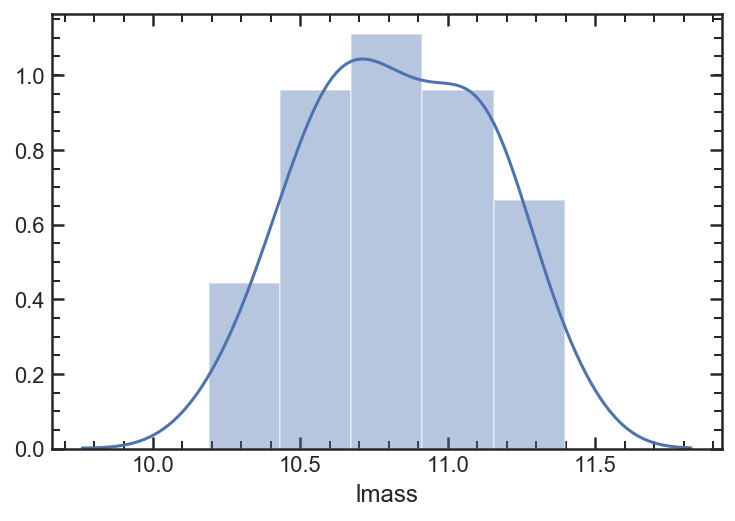

In [37]:
sea.distplot(buldge_meas.lmass)

[2.44696282]


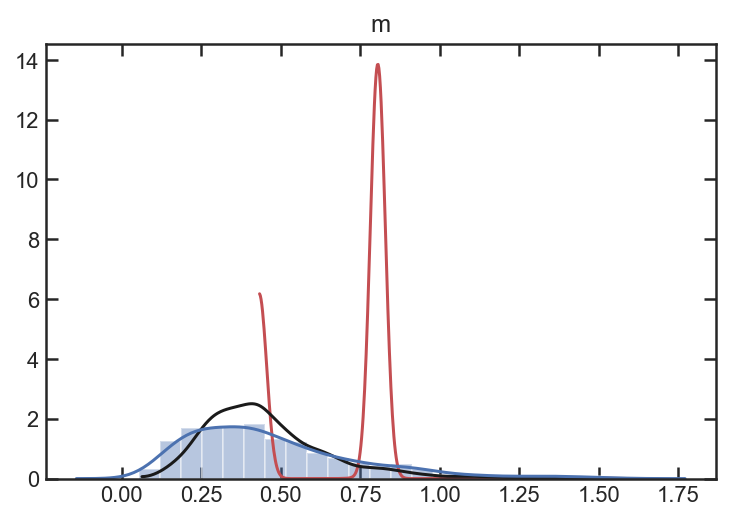

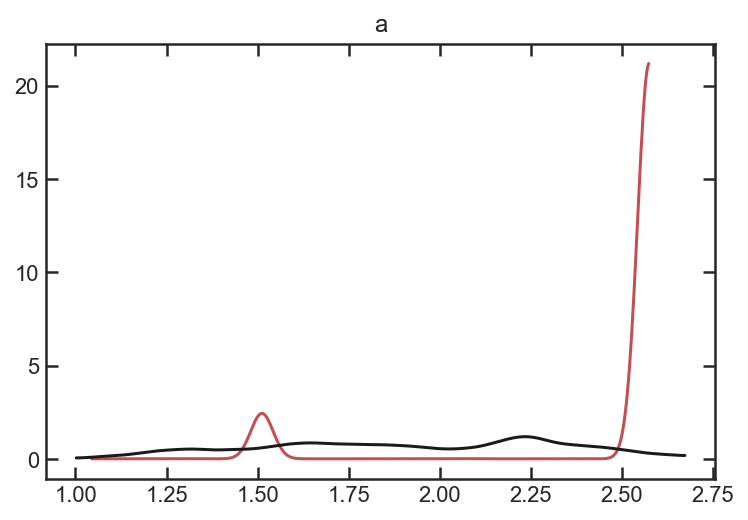

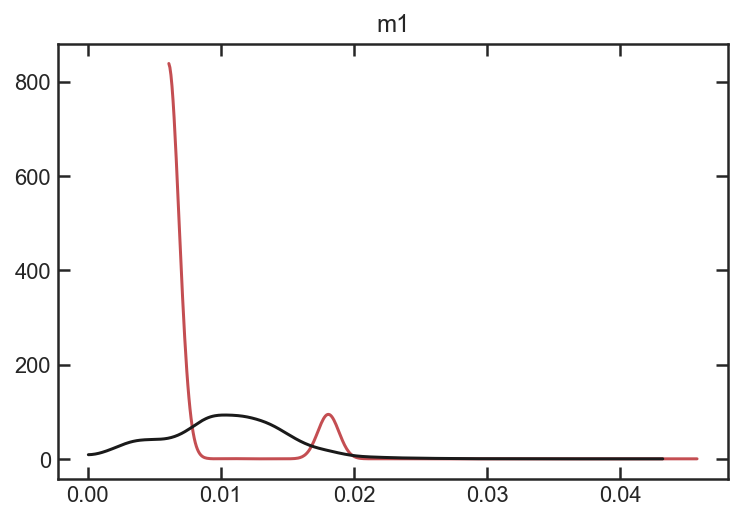

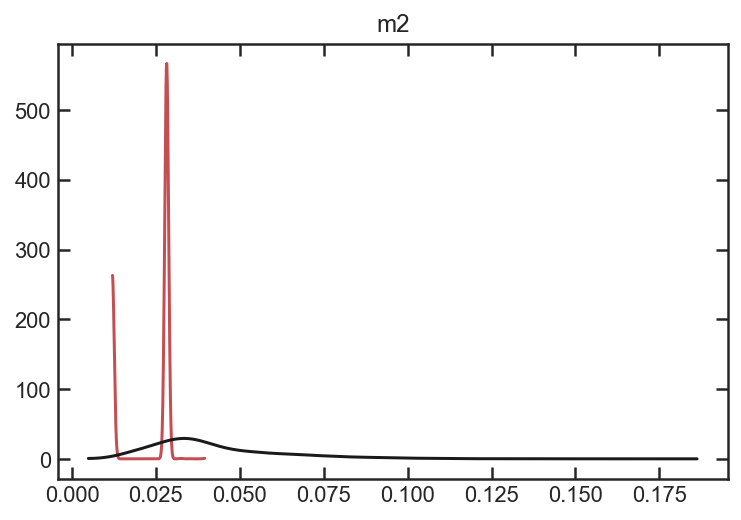

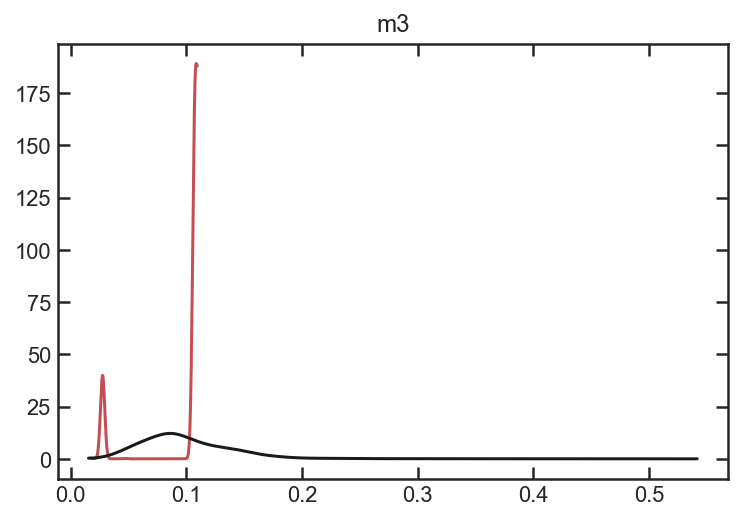

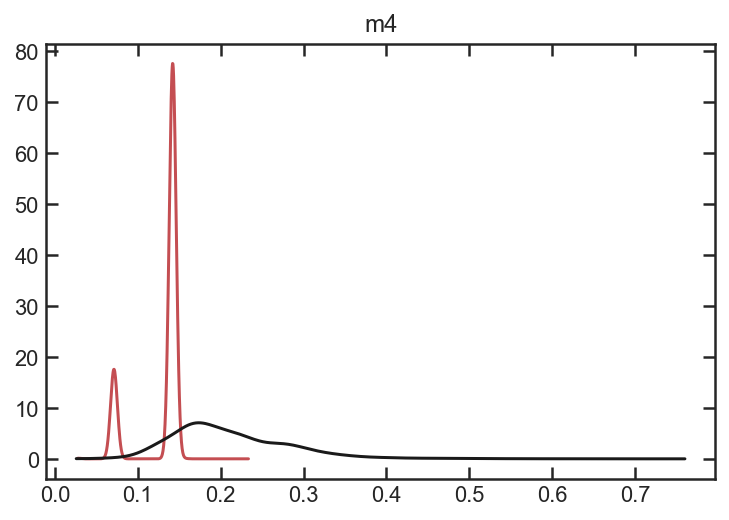

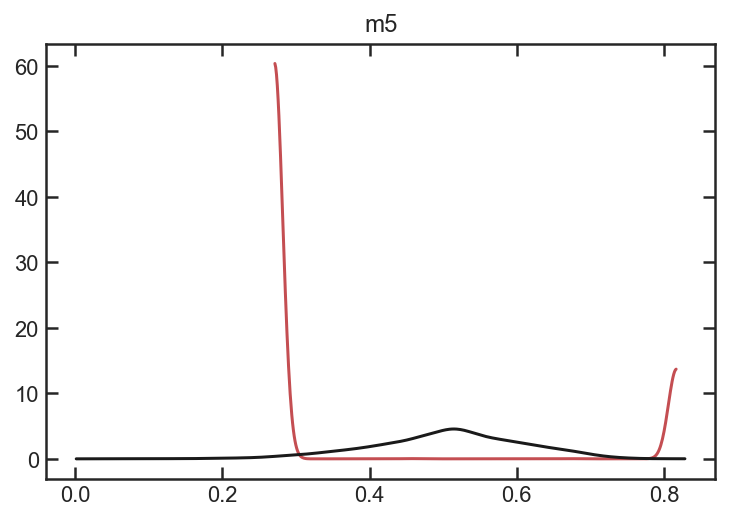

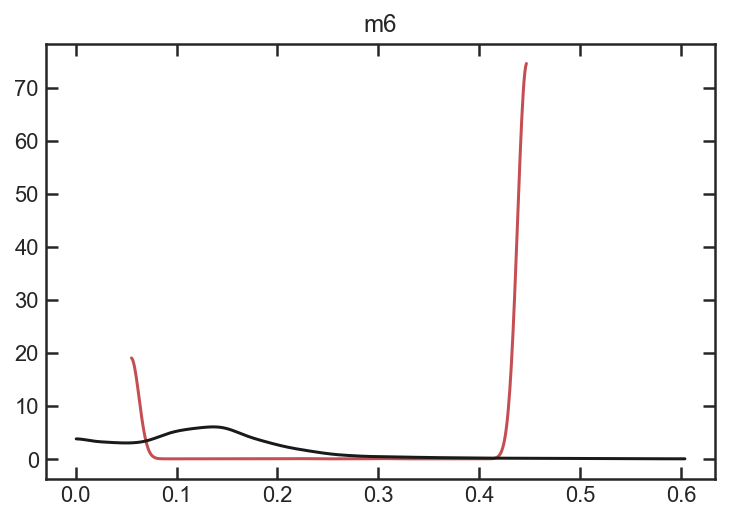

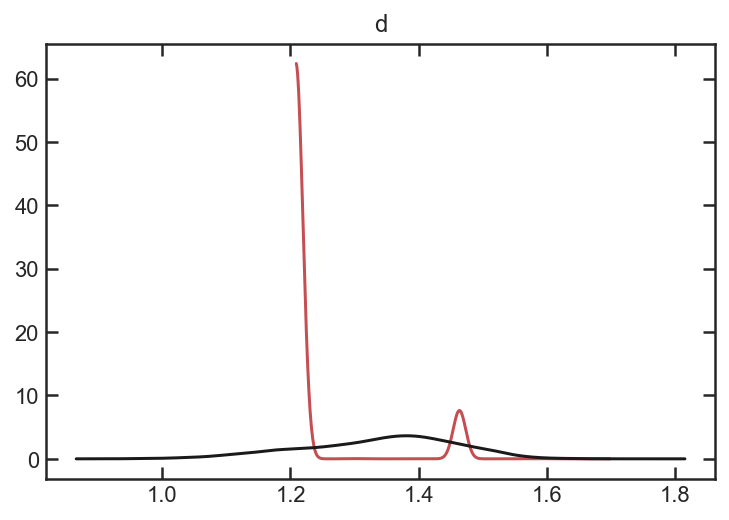

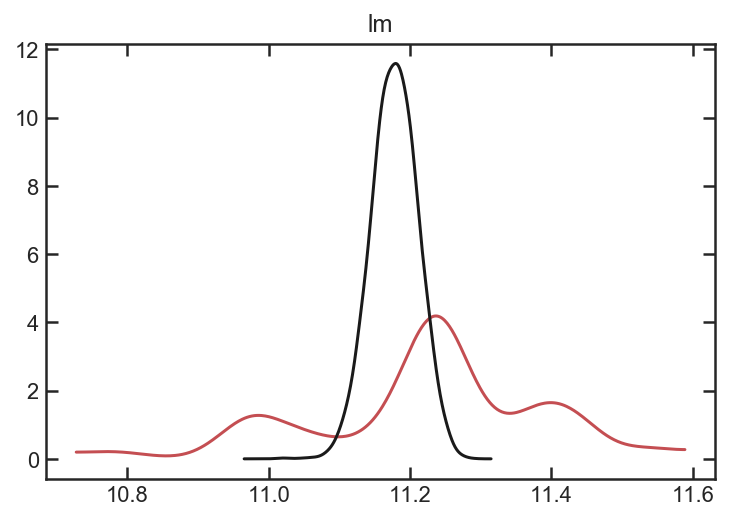

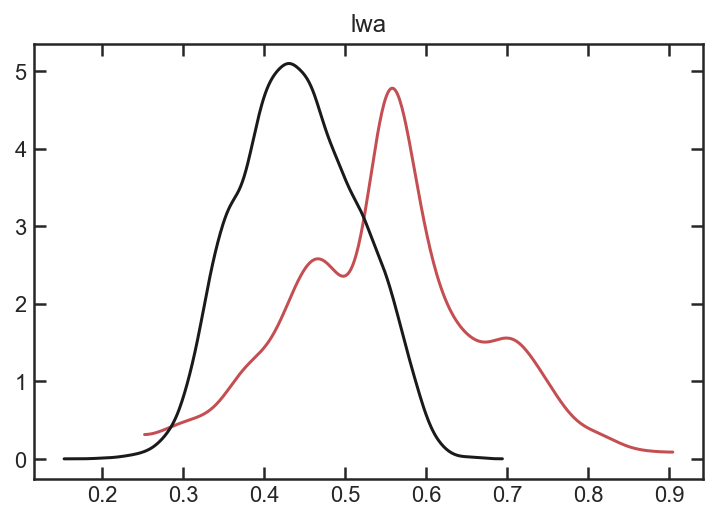

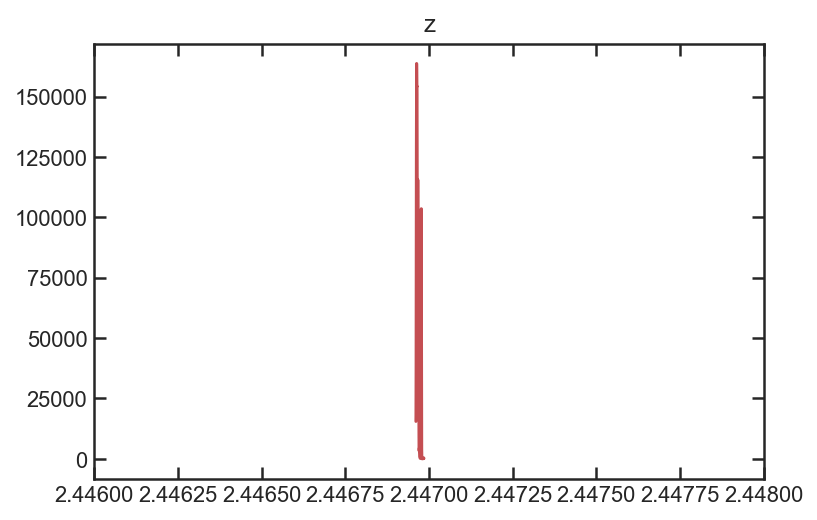

In [42]:
def Z_prior_mu(lmass):
    M = [9, 11.5]
    P = [-0.5813, 0.06818]
    iP = interp1d(M,P)
    return iP(lmass) 

onesig = (0.04 + 0.47)/2
mllim = np.log10(0.001 / 0.019)
mhlim = np.log10(0.031 / 0.019)


params = ['m', 'a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'd', 'lm', 'lwa', 'z']
for i in range(len(params)):
    plt.figure()
    plt.title(params[i])
    
    y,py = np.load('../data/posteriors/GSD_45068_SFMfit_P{0}.npy'.format(params[i]))
    plt.plot(y,py,'r') 
    
    
    if params[i] != 'z':
        y,py = np.load('../Casey_data/posteriors/GSD_45068_SFfit_p1_P{0}.npy'.format(params[i]))
        plt.plot(y,py,'k') 
        
    if params[i] == 'm':
        sea.distplot(10**Gaussian_prior(np.random.rand(1000), [mllim, mhlim], Z_prior_mu(9.732068638965309), onesig))

        
    if params[i] == 'z':
        print(y[py == max(py)])
        plt.xlim(2.446,2.448)

In [22]:
from grizli.utils import SpectrumTemplate
from spec_tools import Gen_PPF
from spec_id_2d import spec_construct

def Derive_nuiscance_SFfits(ppf_dict, sp, Gs, mb_g102, mb_g141, specz, draws = 1000):
    SF_temps =  Gen_temp_dict(specz, 8000, 16000)
    wave0=4000
    linestr = {}
    
    for k in SF_temps:
        linestr[k] = []
    
    
    lm = []
    lwa = []
    sl_b = []
    sl_r = []
    
    idx=0
    while idx < draws:
        try:
            draw = np.zeros(len(params))
            for ii in range(len(draw)):
                draw[ii] = ppf_dict[params[ii]](np.random.rand(1))[0]

            sp.params['dust2'] = draw[8]
            sp.params['logzsol'] = np.log10(draw[0])

            time, sfr, tmax = convert_sfh(get_agebins(draw[1], binnum = 6), draw[2:8], maxage = draw[1]*1E9)

            sp.set_tabular_sfh(time,sfr) 

            wave, flux = sp.get_spectrum(tage = draw[1], peraa = True)

            SF_temps['fsps_model_slope'] = SpectrumTemplate(wave=wave, flux=flux*(wave-wave0)/wave0)
            SF_temps['fsps_model'] = SpectrumTemplate(wave, flux)

            g102_fit = mb_g102.template_at_z(draw[9] , templates=SF_temps, fitter='lstsq')
            g141_fit = mb_g141.template_at_z(draw[9] , templates=SF_temps, fitter='lstsq')

            for k in linestr:
                lineflux = np.array([g102_fit['cfit'][k][0],g141_fit['cfit'][k][0]])

                linestr[k].append(sum(lineflux) / len(lineflux[lineflux > 0]) )

            sl_b.append(g102_fit['cfit']['fsps_model_slope'][0])
            sl_r.append(g141_fit['cfit']['fsps_model_slope'][0])

            wv_obs, flx = spec_construct(g102_fit,g141_fit,draw[9])
            iflux = interp1d(wave*(1+draw[9]), flux)(wv_obs[flx**2 > 0])

            flam = F_lam_per_M(flx * (iflux[50]/flx[50]),wv_obs, draw[9], 0, sp.stellar_mass)
            Pmfl = Gs.Sim_phot_mult(wv_obs,flam)
            scl = Scale_model(Gs.Pflx, Gs.Perr, Pmfl)

            lm.append(np.log10(scl))

            lwa.append(get_lwa_SF(draw[:8], get_agebins(draw[1], binnum = 6),sp)[0])

            idx +=1
        except:
            pass
        
    return lm, lwa, sl_b, sl_r, linestr

In [3]:
field = 'GSD'
galaxy = 45068

beams = mfit_path + '{}_{}.beams.fits'.format(field, galaxy)

mb_g102, mb_g141 = Gen_multibeams(beams, args = args)

sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
sp.params['dust1'] = 0

###########gen spec##########
Gs = Gen_SF_spec(field, galaxy, 1, phot_errterm = 0.04, irac_err = 0.08) 

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 ibhj03xoq_flt.fits G141
2 ibhj03xvq_flt.fits G141
3 ibhj03y2q_flt.fits G141
4 ibhj03y9q_flt.fits G141
5 ibhj11hiq_flt.fits G141
6 ibhj11hpq_flt.fits G141
7 ibhj11hwq_flt.fits G141
8 ibhj11i3q_flt.fits G141
9 icxt01cgq_flt.fits G102
10 icxt01ciq_flt.fits G102
11 icxt01clq_flt.fits G102
12 icxt01cnq_flt.fits G102
13 icxt02c7q_flt.fits G102
14 icxt02caq_flt.fits G102
15 icxt02cdq_flt.fits G102
16 icxt02cfq_flt.fits G102
17 icxt03jjq_flt.fits G102
18 icxt03jkq_flt.fits G102
19 icxt03jnq_flt.fits G102
20 icxt03jpq_flt.fits G102
21 icxt04e3q_flt.fits G102
22 icxt04edq_flt.fits G102
23 icxt04efq_flt.fits G102
24 icxt05h7q_flt.fits G102
25 icxt05h9q_flt.fits G102
26 icxt05hcq_flt.fits G102
27 icxt05heq_flt.fits G102
28 icxt06laq_flt.fits G102
29 icxt06lcq_flt.fits G102
30 icxt06lfq_flt.fits G102
31 icxt06lhq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

In [7]:
params = ['m', 'a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'd', 'z']
#        [ 0 ,  1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,  8 ,  9 ]

ppf_dict = {}

for i in params:
    x,px = np.load('../data/posteriors/GSD_45068_SFMfit_P{}.npy'.format(i))
    ppf_dict[i] = Gen_PPF(x,px)

In [23]:
lm, lwa, slB, slR, linestr = Derive_nuiscance_SFfits(ppf_dict, sp, Gs, mb_g102, mb_g141, 2.44696282, draws=1000)


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in double_scalars
/Users/vestrada/Github/Cluster_and_field/scripts/spec_id_2d.py:130: RuntimeWarning: invalid value encountered in true_divide
  line_g141 = (g141_fit['line1d'].flux - g141_fit['cont1d'].flux)/g141_fit['cont1d'].flux
/Users/vestrada/Github/Cluster_and_field/scripts/spec_id_2d.py:139: RuntimeWarning: invalid value encountered in true_divide
  line_g102 = (g102_fit['line1d'].flux - g102_fit['cont1d'].flux)/g102_fit['cont1d'].flux
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater


In [24]:
from spec_tools import boot_to_posterior

LM, PLM = boot_to_posterior(lm, np.ones_like(lm))
np.save('../data/posteriors/GSD_45068_SFMfit_Plm', [LM, PLM])

LWA, PLWA = boot_to_posterior(lwa, np.ones_like(lwa))
np.save('../data/posteriors/GSD_45068_SFMfit_Plwa', [LWA, PLWA])

SLB, PSLB = boot_to_posterior(slB, np.ones_like(slB))
np.save('../data/posteriors/GSD_45068_SFMfit_Pslb', [SLB, PSLB])

SLR, PSLR = boot_to_posterior(slR, np.ones_like(slR))
np.save('../data/posteriors/GSD_45068_SFMfit_Pslr', [SLR, PSLR])

In [28]:
linestr.keys()

dict_keys(['line OII', 'line NeVI-3426', 'line NeV-3346', 'line H10', 'line OIII-4363', 'line H7', 'line NeIII-3867', 'line H8', 'line Hd', 'line MgII', 'line Hg', 'line H9'])

In [36]:
lnflx = np.array(linestr['line NeV-3346'])
lnflx = lnflx[~np.isinf(lnflx)]
lnflx = lnflx[~np.isnan(lnflx)]

array([-4.28394840e-17, -4.31339988e-17, -4.34703387e-17, -4.25714732e-17,
       -4.15980566e-17, -4.16529479e-17, -4.11748434e-17, -4.17607759e-17,
       -4.34118195e-17, -3.99621703e-17, -4.33256334e-17, -4.35690168e-17,
       -4.32041749e-17, -4.18197040e-17, -4.20820695e-17, -3.92643039e-17,
       -4.17153290e-17, -4.49424942e-17, -4.35709711e-17, -4.22845935e-17,
       -4.29329043e-17, -3.92655590e-17, -4.42994714e-17, -4.19255714e-17,
       -4.36064726e-17, -4.18596582e-17, -4.35481976e-17, -4.18588303e-17,
       -4.09400055e-17, -3.99729949e-17, -4.06269408e-17, -4.22115785e-17,
       -4.35347493e-17, -4.31271384e-17, -4.13009920e-17, -4.39671791e-17,
       -4.44011040e-17, -4.36034185e-17, -4.17530370e-17, -4.31730862e-17,
       -4.26106574e-17, -4.25335545e-17, -4.33043648e-17, -4.35675689e-17,
       -4.43496403e-17, -4.32694585e-17, -4.32711410e-17, -4.20345467e-17,
       -4.11899579e-17, -4.39232395e-17, -4.51063168e-17, -4.30702966e-17,
       -4.24473132e-17, -

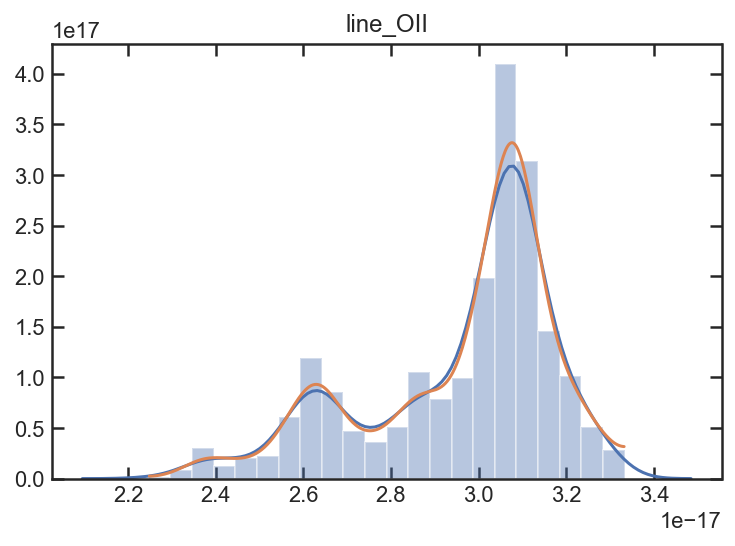

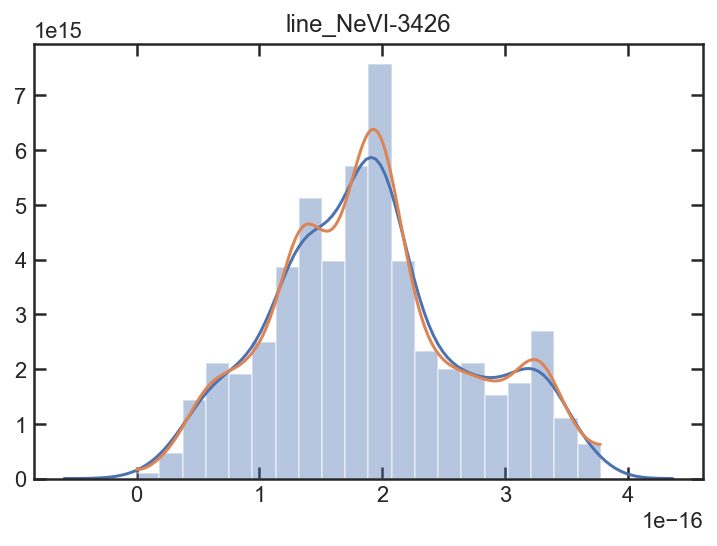

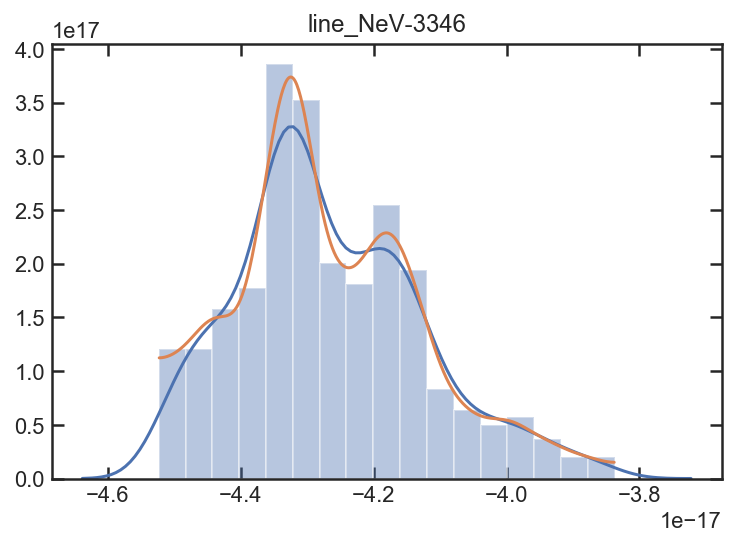

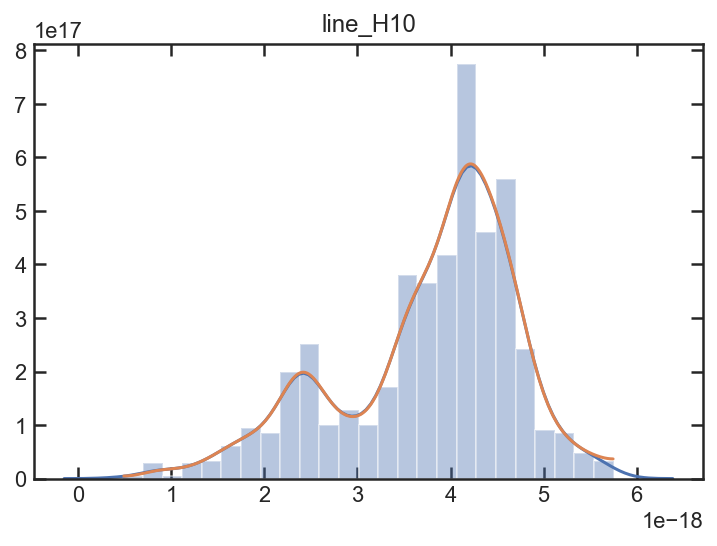

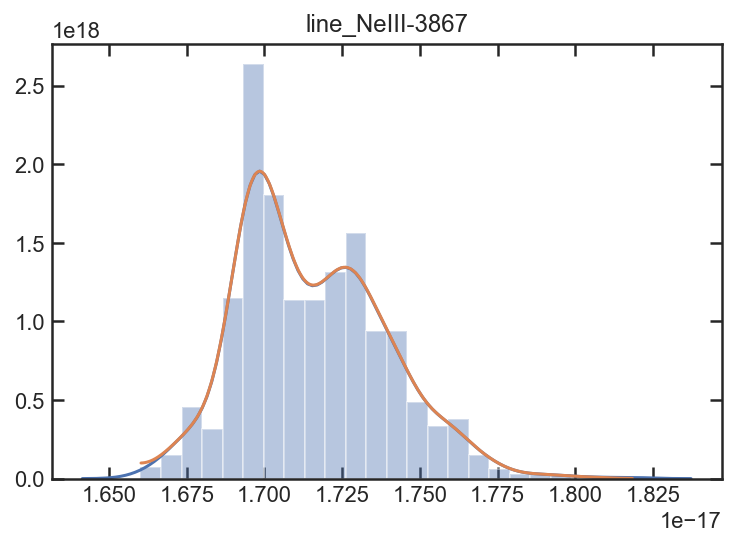

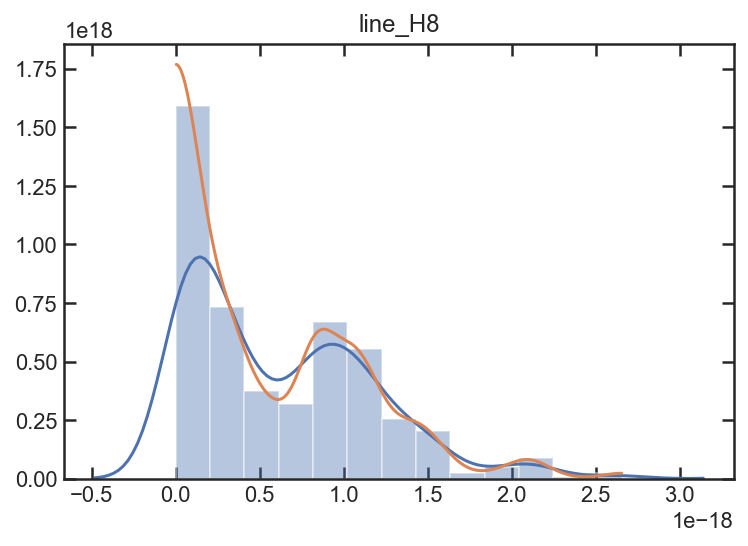

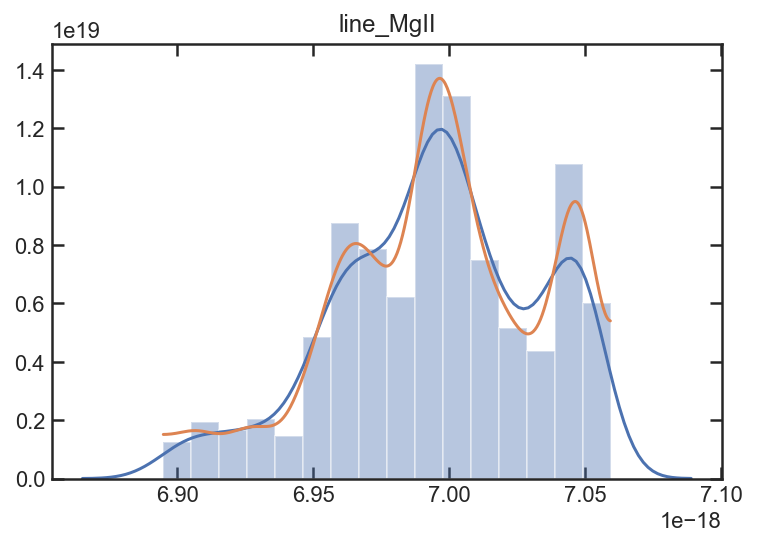

In [41]:
for i in linestr:
    lnflx = np.array(linestr[i])
    lnflx = lnflx[~np.isinf(lnflx)]
    lnflx = lnflx[~np.isnan(lnflx)]
    
    try:
        X, PX = boot_to_posterior(lnflx, np.ones_like(lnflx))

        plt.figure()
        sea.distplot(lnflx)
        plt.plot(X,PX)
        plt.title(i.split(' ')[0] + '_' + i.split(' ')[1])

        np.save('../data/posteriors/GSD_45068_SFMfit_P{}'.format(i.split(' ')[0] + '_' + i.split(' ')[1]), [X,PX])

        
    except:
        pass


In [48]:
from spec_tools import Derive_SFH_weights, z_at_value, boot_to_posterior, Rescale_SF_sfh
import astropy.units as u
class Rescale_SF_sfh_m(object):
    def __init__(self, field, galaxy, trials = 1000):

        ppf_dict = {}
        params = ['a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'lm']

        for i in params:
            x,px = np.load('../data/posteriors/{0}_{1}_SFMfit_P{2}.npy'.format(field, galaxy, i))
            ppf_dict[i] = Gen_PPF(x,px)

        idx = 0
        x,px = np.load('../data/posteriors/{0}_{1}_SFMfit_Pz.npy'.format(field, galaxy))
        rshift = x[px == max(px)][0]
        self.fulltimes = np.arange(0.0,Oldest_galaxy(rshift),0.01)
        sfr_grid = []
        ssfr_grid = []
        t_50_grid = []

        while idx < trials:
            try:
                draw = np.zeros(len(params))

                for i in range(len(draw)):
                    draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

                time, sfr, tmax = convert_sfh(get_agebins(draw[0], binnum=6), draw[1:7], maxage = draw[0]*1E9)

                T=[0]
                M=[0]
                for i in range(len(time)//2):
                    mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
                    M.append(M[i] + mass)
                    T.append(time[i*2+1])

                sfr = sfr/ M[-1] * 10**draw[7] / 1E9

                lbt = np.abs(time - time[-1])[::-1]
                lbsfr = sfr[::-1]

                T=[0]
                M=[0]
                for i in range(len(lbt)//2):
                    mass = lbsfr[i*2+1] * (lbt[i*2+1] - lbt[i*2])
                    M.append(M[i] + mass)
                    T.append(lbt[i*2+1])

                t_50_grid.append(interp1d(M/ M[-1], T)(0.5))

                sfrmax = np.argmax(lbsfr) 

                sfr_grid.append(interp1d(lbt,lbsfr,bounds_error=False,fill_value=0)(self.fulltimes))

                ssfr_grid.append(lbsfr[0] / 10**draw[7])
                idx +=1
            except:
                pass

        SFH = []
        SFH_16 = []
        SFH_84 = []
        ftimes = []
        for i in range(len(np.array(sfr_grid).T)):
            adat = np.array(np.array(sfr_grid).T[i])
            gdat = adat[adat>0]
            if len(gdat) < trials * 0.1:
                break
            else:
                SFH.append(np.percentile(gdat,50))
                SFH_16.append(np.percentile(gdat,16))
                SFH_84.append(np.percentile(gdat,84))

                ftimes.append(self.fulltimes[i])
                
        self.SFH = np.array(SFH)
        self.SFH_16 = np.array(SFH_16)
        self.SFH_84 = np.array(SFH_84)
        self.LBT = np.array(ftimes)
        
        self.sfr_grid = np.ma.masked_less_equal(sfr_grid,1E-10)

        weights = Derive_SFH_weights(self.SFH, sfr_grid[0:trials])
       
        ####### t values
        x,y = boot_to_posterior(t_50_grid[0:trials], weights)
        self.t_50, self.t_50_hci, self.t_50_offreg = Highest_density_region(y,x)
        
        self.t_50 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.5)

        ####### z values
        self.z_50 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_50)*u.Gyr)
        hci=[]
        for lims in self.t_50_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_50_hci = np.array(hci)
        self.z_50_offreg = np.array(self.t_50_offreg)

            
        x,y = boot_to_posterior(np.log10(ssfr_grid[0:trials]), weights)
        self.lssfr, self.lssfr_hci, self.lssfr_offreg = Highest_density_region(y,x)
            
        self.weights = weights
        self.t_50_grid = t_50_grid

In [49]:
sfh1 = Rescale_SF_sfh('GSD', 45068, 2.44696282,'fit_p1')
sfh2 = Rescale_SF_sfh_m('GSD', 45068)

(0, 400)

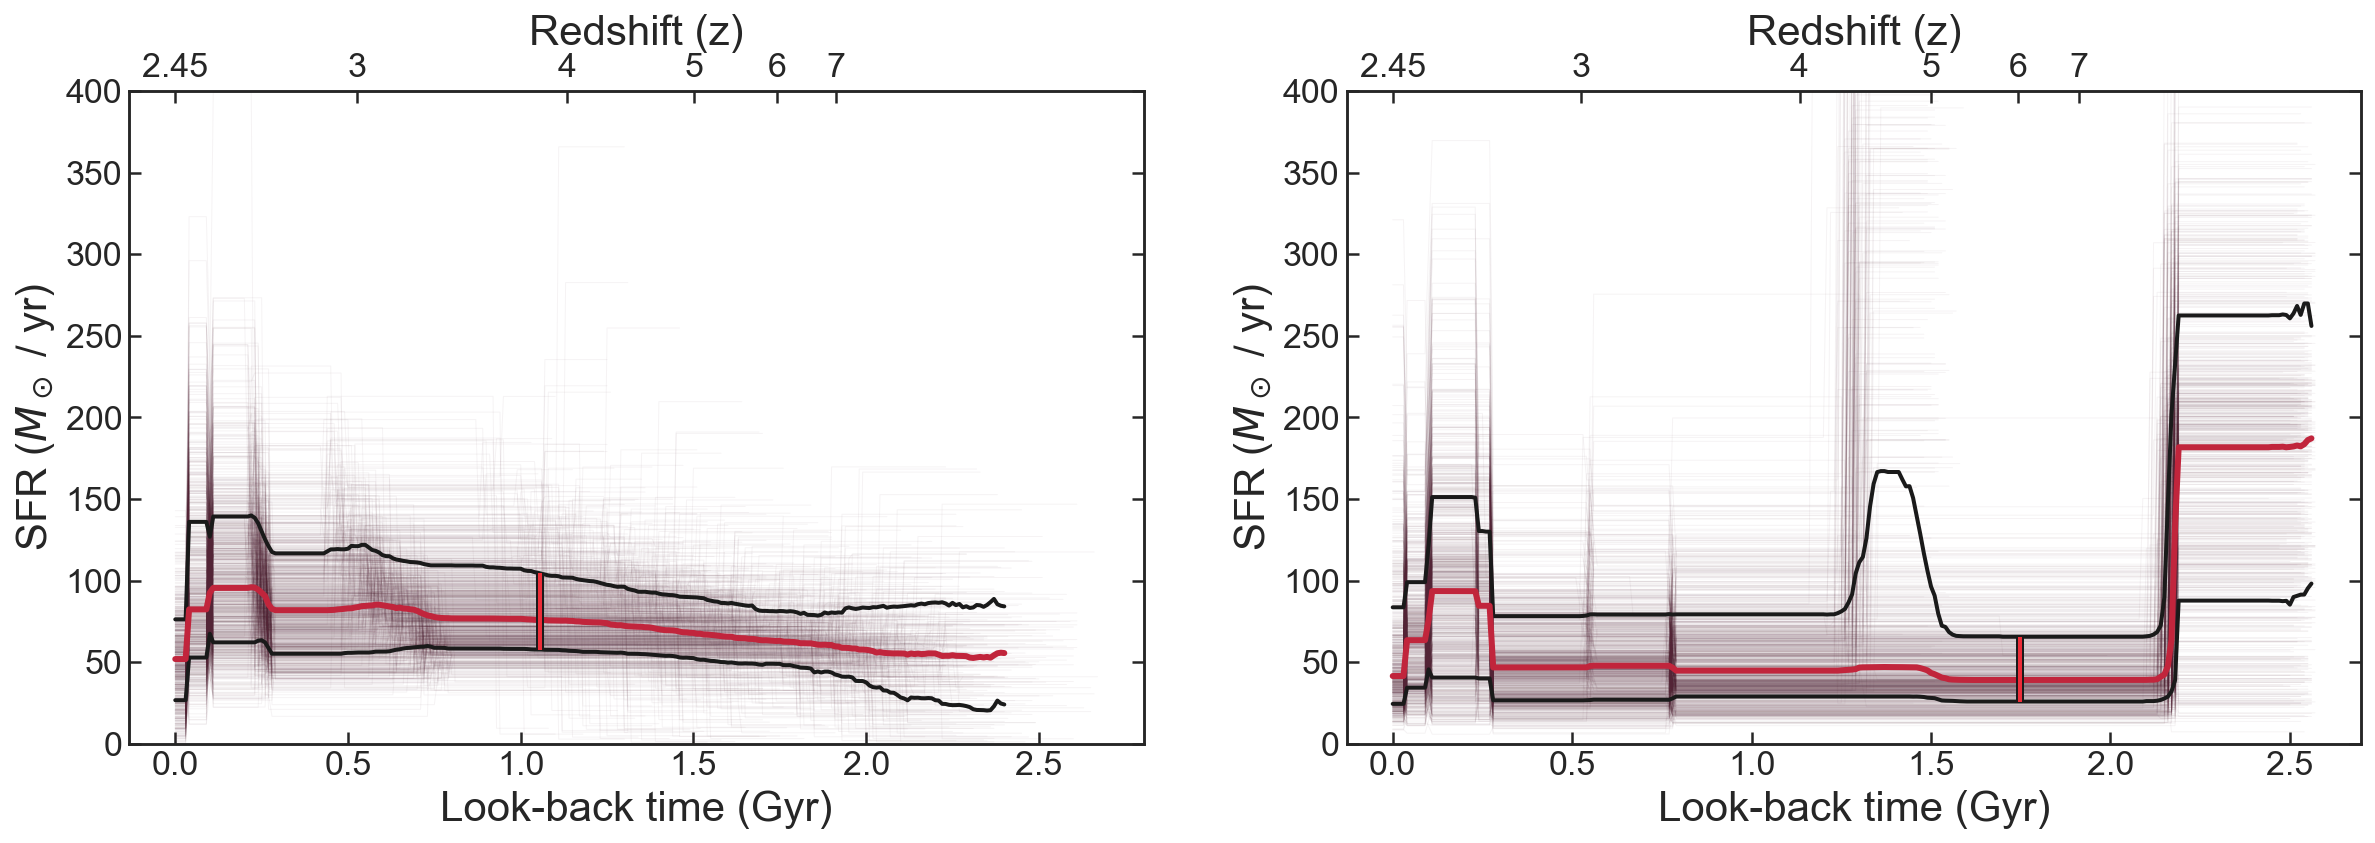

In [54]:
gs = gridspec.GridSpec(1,2)


plt.figure(figsize=[20,6])
ax3 = plt.subplot(gs[0])

isfhl = interp1d(sfh1.LBT,sfh1.SFH_16)
isfhh = interp1d(sfh1.LBT,sfh1.SFH_84)

ax4 = ax3.twiny()

ax3.plot(sfh1.fulltimes, sfh1.sfr_grid.T[:1000], color = '#532436', alpha=.05, linewidth = 0.5)
ax3.plot(sfh1.LBT,sfh1.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
ax3.plot(sfh1.LBT,sfh1.SFH_16, 'k', linewidth = 2)
ax3.plot(sfh1.LBT,sfh1.SFH_84, 'k', linewidth = 2)

max_lbt = np.round(sfh1.fulltimes[-1])
max_age = max_lbt + cosmo.lookback_time(2.44696282).value
age_at_z = cosmo.lookback_time(2.44696282).value
zarray = [np.round(2.44696282,2)]

idx = 0
while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
    zarray.append(int(zarray[idx])+1)
    idx += 1 
    
tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

ax4.set_xlim(ax3.get_xlim())
ax4.set_xticks(tarray)
ax4.set_xticklabels(zarray)
ax4.xaxis.set_ticks_position('top')

ax3.set_xlabel('Look-back time (Gyr)', fontsize=21)
ax3.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=21)
ax4.set_xlabel('Redshift (z)', fontsize=21) 
ax3.tick_params(axis='both', which='major', labelsize=17)
ax4.tick_params(axis='both', which='major', labelsize=17)

ax3.vlines(sfh1.t_50,isfhl(sfh1.t_50), isfhh(sfh1.t_50), color = '#ED2D39', linewidth = 2, zorder = 11)
ax3.vlines(sfh1.t_50,isfhl(sfh1.t_50), isfhh(sfh1.t_50), color = 'k', linewidth = 4, zorder = 10)
ax3.set_ylim(0,400)

ax3 = plt.subplot(gs[1])

isfhl = interp1d(sfh2.LBT,sfh2.SFH_16)
isfhh = interp1d(sfh2.LBT,sfh2.SFH_84)

ax4 = ax3.twiny()

ax3.plot(sfh2.fulltimes, sfh2.sfr_grid.T[:1000], color = '#532436', alpha=.05, linewidth = 0.5)
ax3.plot(sfh2.LBT,sfh2.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
ax3.plot(sfh2.LBT,sfh2.SFH_16, 'k', linewidth = 2)
ax3.plot(sfh2.LBT,sfh2.SFH_84, 'k', linewidth = 2)

max_lbt = np.round(sfh2.fulltimes[-1])
max_age = max_lbt + cosmo.lookback_time(2.44696282).value
age_at_z = cosmo.lookback_time(2.44696282).value
zarray = [np.round(2.44696282,2)]

idx = 0
while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
    zarray.append(int(zarray[idx])+1)
    idx += 1 
    
tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

ax4.set_xlim(ax3.get_xlim())
ax4.set_xticks(tarray)
ax4.set_xticklabels(zarray)
ax4.xaxis.set_ticks_position('top')

ax3.set_xlabel('Look-back time (Gyr)', fontsize=21)
ax3.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=21)
ax4.set_xlabel('Redshift (z)', fontsize=21) 
ax3.tick_params(axis='both', which='major', labelsize=17)
ax4.tick_params(axis='both', which='major', labelsize=17)

ax3.vlines(sfh2.t_50,isfhl(sfh2.t_50), isfhh(sfh2.t_50), color = '#ED2D39', linewidth = 2, zorder = 11)
ax3.vlines(sfh2.t_50,isfhl(sfh2.t_50), isfhh(sfh2.t_50), color = 'k', linewidth = 4, zorder = 10)
ax3.set_ylim(0,400)
